In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import os

In [2]:
for dirname, _, filenames in os.walk('.\Data Sources'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

.\Data Sources\Base.csv
.\Data Sources\Variant I.csv
.\Data Sources\Variant II.csv
.\Data Sources\Variant III.csv
.\Data Sources\Variant IV.csv
.\Data Sources\Variant V.csv


In [3]:
results = []

def store_results(model_name, dataset_name, accuracy, roc_auc, fpr):
    results.append({
        'Model': model_name,
        'Dataset': dataset_name,
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'FPR': fpr
    })


In [4]:
def train_and_evaluate_model(csv_file_path):
    # Read data from CSV file
    df = pd.read_csv(csv_file_path)

    # # Display data information overview
    # print("Data information:")
    # print(df.info())
    # print("\nDescriptive statistics of the data:")
    # print(df.describe())

    # Process categorical columns
    categorical_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))  # Convert to string before encoding
        label_encoders[col] = le  # Save LabelEncoder for reverse if needed

    # Split data into features and target
    X = df.drop(columns=['fraud_bool'])  # Assume 'fraud_bool' is the target column
    y = df['fraud_bool']

    # Split data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to balance the data
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    # Display the number of instances after applying SMOTE
    print(f"Number of instances after applying SMOTE: {np.sum(y_train_res == 1)} fraud, {np.sum(y_train_res == 0)} non-fraud")

    # Create LightGBM dataset
    train_data_res = lgb.Dataset(X_train_res, label=y_train_res)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data_res)

    # Configure LightGBM parameters
    params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }
    num_round = 100

    # Train the model with LightGBM
    bst = lgb.train(params, train_data_res, num_round, valid_sets=[test_data])

    # Predict on the test set
    y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
    y_pred_binary = (y_pred >= 0.5).astype(int)

    # Evaluate the model
    print("\nModel evaluation:")
    print("Accuracy: ", accuracy_score(y_test, y_pred_binary))
    print("Classification Report:\n", classification_report(y_test, y_pred_binary))
    print("ROC AUC: ", roc_auc_score(y_test, y_pred))

    # Calculate False Positive Rate (FPR)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    fpr = fp / (fp + tn)  # Calculate FPR
    print("False Positive Rate (FPR): ", fpr)

    # Visualize feature importance
    lgb.plot_importance(bst, max_num_features=10, importance_type='split', figsize=(10, 6))
    plt.title("Feature Importance (Top 10)")
    plt.show()

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_binary)
    roc_auc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    fpr = fp / (fp + tn)
    
    # Store the results
    store_results('LightGBM', csv_file_path, accuracy, roc_auc, fpr)


In [5]:
def train_and_evaluate_model_xgboost(csv_file_path):
    # Read data from CSV file
    df = pd.read_csv(csv_file_path)

    # # Display data information overview
    # print(df.info())
    # print(df.describe())

    # Process categorical columns: use LabelEncoder to convert object columns to numbers
    categorical_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

    # Apply LabelEncoder to each categorical column
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))  # Convert to string before encoding
        label_encoders[col] = le  # Save le to reverse if needed

    # Split into features and target
    X = df.drop(columns=['fraud_bool'])  # Assume 'fraud_bool' is the target column
    y = df['fraud_bool']

    # Split data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to balance the data
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Define basic parameters for XGBoost model
    params = {
        'objective': 'binary:logistic',  # Binary classification
        'eval_metric': 'auc',            # Evaluate AUC
        'n_estimators': 1000,            # Number of decision trees
        'random_state': 42,
        'learning_rate': 0.031,          # Lower learning rate
        'max_depth': 8,                  # Maximum depth of each tree
        'min_child_weight': 100,         # Minimum weight of each child (helps reduce overfitting and improve recall)
        'subsample': 0.9,                # Ratio of samples taken randomly in each tree
        'colsample_bytree': 0.8,         # Ratio of features selected randomly for each tree
        'gamma': 1,                      # Regularization parameter for model complexity
        'scale_pos_weight': 1,           # Increase weight of positive class to help model learn better with fraud class
        'lambda': 1,                     # L2 regularization
        'alpha': 0.5,                    # L1 regularization
        'early_stopping_rounds': 200,    # Stop training if no improvement in 50 rounds
    }

    # Create dataset for XGBoost
    dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Train XGBoost model
    bst = xgb.train(params, dtrain, 200, evals=[(dtest, 'eval')])

    # Predict on the test set
    y_pred = bst.predict(dtest)
    y_pred_binary = (y_pred >= 0.5).astype(int)

    # Evaluate the model
    print("Accuracy: ", accuracy_score(y_test, y_pred_binary))
    print("Classification Report:\n", classification_report(y_test, y_pred_binary))
    print("ROC AUC: ", roc_auc_score(y_test, y_pred))

    # Calculate False Positive Rate (FPR)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    fpr = fp / (fp + tn)  # Calculate FPR
    print("False Positive Rate (FPR): ", fpr)

    # Visualize feature importance
    xgb.plot_importance(bst, importance_type='weight', max_num_features=10, height=0.5)
    plt.title("Feature Importance (Top 10)")
    plt.show()

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_binary)
    roc_auc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    fpr = fp / (fp + tn)
    
    # Store the results
    store_results('XGBoost', csv_file_path, accuracy, roc_auc, fpr)


In [6]:
def train_and_evaluate_random_forest(csv_file_path):
    # Read data from CSV file
    df = pd.read_csv(csv_file_path)

    # Process categorical columns: use LabelEncoder to convert object columns to numbers
    categorical_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

    # Apply LabelEncoder to each categorical column
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))  # Convert to string before encoding
        label_encoders[col] = le  # Save le to reverse if needed

    # Split into features and target
    X = df.drop(columns=['fraud_bool'])  # Assume 'fraud_bool' is the target column
    y = df['fraud_bool']

    # Split data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to balance the data
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Define and train the model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_res, y_train_res)

    # Evaluate the model
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)
    
    # Store the results
    store_results('RandomForest', csv_file_path, accuracy, roc_auc, fpr)


In [7]:
def train_and_evaluate_logistic_regression(csv_file_path):
    # Read data from CSV file
    df = pd.read_csv(csv_file_path)

    # Process categorical columns: use LabelEncoder to convert object columns to numbers
    categorical_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

    # Apply LabelEncoder to each categorical column
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))  # Convert to string before encoding
        label_encoders[col] = le  # Save le to reverse if needed

    # Split into features and target
    X = df.drop(columns=['fraud_bool'])  # Assume 'fraud_bool' is the target column
    y = df['fraud_bool']

    # Split data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to balance the data
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    # Define and train the model
    lr = LogisticRegression(random_state=42)
    lr.fit(X_train_res, y_train_res)

    # Evaluate the model
    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)
    
    # Store the results
    store_results('LogisticRegression', csv_file_path, accuracy, roc_auc, fpr)


In [8]:

def train_and_evaluate_knn(csv_file_path):
    # Read data from CSV file
    df = pd.read_csv(csv_file_path)

    # Process categorical columns: use LabelEncoder to convert object columns to numbers
    categorical_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

    # Apply LabelEncoder to each categorical column
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))  # Convert to string before encoding
        label_encoders[col] = le  # Save le to reverse if needed

    # Split into features and target
    X = df.drop(columns=['fraud_bool'])  # Assume 'fraud_bool' is the target column
    y = df['fraud_bool']

    # Split data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to balance the data
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Define and train the model
    knn = KNeighborsClassifier()
    knn.fit(X_train_res, y_train_res)

    # Evaluate the model
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)
    
    # Store the results
    store_results('KNN', csv_file_path, accuracy, roc_auc, fpr)


In [9]:
def select_and_run(data_choice, model_choice):
    # Paths to different versions of the data
    data_paths = [
        './Data Sources/Base.csv',
        './Data Sources/Variant I.csv',
        './Data Sources/Variant II.csv',
        './Data Sources/Variant III.csv',
        './Data Sources/Variant IV.csv',
        './Data Sources/Variant V.csv'
    ]

    # Check if the choice is valid
    if 0 <= data_choice <= 5:
        selected_path = data_paths[data_choice]
        print(f"Processing data from: {selected_path}")
        
        # Choose training model
        if model_choice == 1:
            print("Using LightGBM model...")
            train_and_evaluate_model(selected_path)  # Call LightGBM function
        elif model_choice == 2:
            print("Using XGBoost model...")
            train_and_evaluate_model_xgboost(selected_path)  # Call XGBoost function
        elif model_choice == 3:
            print("Using Random Forest model...")
            train_and_evaluate_random_forest(selected_path)  # Call Random Forest function
        elif model_choice == 4:
            print("Using Logistic Regression model...")
            train_and_evaluate_logistic_regression(selected_path)  # Call Logistic Regression function
        elif model_choice == 5:
            print("Using KNN model...")
            train_and_evaluate_knn(selected_path)  # Call KNN function
        else:
            print("Invalid model choice. Please choose 1, 2, 3, 4, 5, or 6.")
    else:
        print("Invalid data choice. Please choose a number from 0 to 5.")


Processing data from: ./Data Sources/Base.csv
Using LightGBM model...
Number of instances after applying SMOTE: 791080 fraud, 791080 non-fraud
[LightGBM] [Info] Number of positive: 791080, number of negative: 791080
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3770
[LightGBM] [Info] Number of data points in the train set: 1582160, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Model evaluation:
Accuracy:  0.97162
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    197891
           1       0.11      0.24      0.15      2109

    accuracy                           0.97    200000
   macro avg       0.55      0.61      0.57    200000
weighted avg    

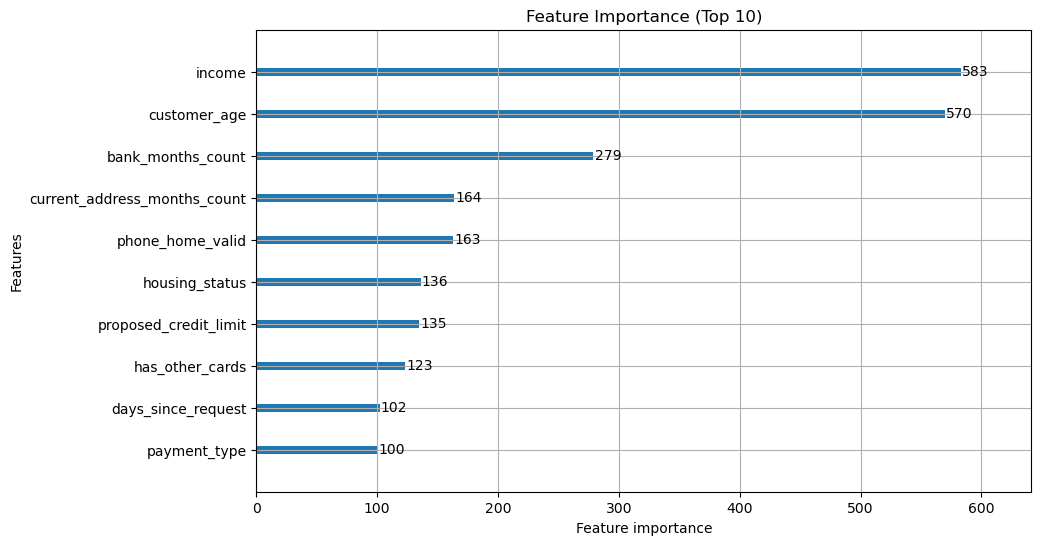

Processing data from: ./Data Sources/Base.csv
Using XGBoost model...


c:\Users\Kyles\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [01:16:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	eval-auc:0.80005
[1]	eval-auc:0.79872
[2]	eval-auc:0.80079
[3]	eval-auc:0.80375
[4]	eval-auc:0.81023
[5]	eval-auc:0.80993
[6]	eval-auc:0.81430
[7]	eval-auc:0.81473
[8]	eval-auc:0.81492
[9]	eval-auc:0.81538
[10]	eval-auc:0.81772
[11]	eval-auc:0.81787
[12]	eval-auc:0.81820
[13]	eval-auc:0.81952
[14]	eval-auc:0.81984
[15]	eval-auc:0.82095
[16]	eval-auc:0.81981
[17]	eval-auc:0.82122
[18]	eval-auc:0.82122
[19]	eval-auc:0.82340
[20]	eval-auc:0.82327
[21]	eval-auc:0.82312
[22]	eval-auc:0.82301
[23]	eval-auc:0.82278
[24]	eval-auc:0.82480
[25]	eval-auc:0.82480
[26]	eval-auc:0.82505
[27]	eval-auc:0.82588
[28]	eval-auc:0.82553
[29]	eval-auc:0.82555
[30]	eval-auc:0.82548
[31]	eval-auc:0.82545
[32]	eval-auc:0.82547
[33]	eval-auc:0.82577
[34]	eval-auc:0.82593
[35]	eval-auc:0.82622
[36]	eval-auc:0.82615
[37]	eval-auc:0.82618
[38]	eval-auc:0.82604
[39]	eval-auc:0.82691
[40]	eval-auc:0.82696
[41]	eval-auc:0.82709
[42]	eval-auc:0.82700
[43]	eval-auc:0.82701
[44]	eval-auc:0.82714
[45]	eval-auc:0.8276

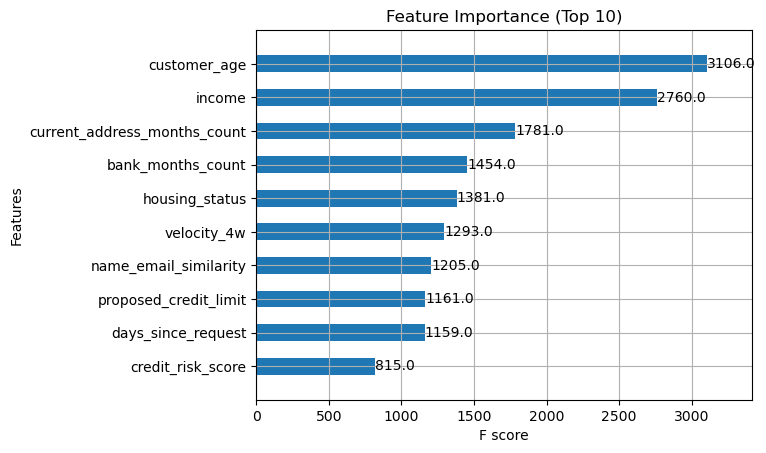

Processing data from: ./Data Sources/Base.csv
Using Random Forest model...
Processing data from: ./Data Sources/Base.csv
Using Logistic Regression model...


c:\Users\Kyles\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Processing data from: ./Data Sources/Base.csv
Using KNN model...


c:\Users\Kyles\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [10]:
# Run the function to select data versions and train models
'''for i in range(0, 6):
    select_and_run(i, 1)
    select_and_run(i, 2)
    select_and_run(i, 3)
    select_and_run(i, 4)
    select_and_run(i, 5)'''
select_and_run(0, 1)
select_and_run(0, 2)
select_and_run(0, 3)
select_and_run(0, 4)
select_and_run(0, 5)

In [11]:
# After running all models
results_df = pd.DataFrame(results)
print(results_df)

# Calculate average metrics for each model
average_results = results_df.groupby('Model').mean()
print(average_results)

                Model                  Dataset  Accuracy   ROC AUC       FPR
0            LightGBM  ./Data Sources/Base.csv  0.971620  0.842194  0.020577
1             XGBoost  ./Data Sources/Base.csv  0.967685  0.848978  0.024892
2        RandomForest  ./Data Sources/Base.csv  0.980920  0.548461  0.009763
3  LogisticRegression  ./Data Sources/Base.csv  0.653195  0.677450  0.347328
4                 KNN  ./Data Sources/Base.csv  0.885580  0.541095  0.106998
                    Accuracy   ROC AUC       FPR
Model                                           
KNN                 0.885580  0.541095  0.106998
LightGBM            0.971620  0.842194  0.020577
LogisticRegression  0.653195  0.677450  0.347328
RandomForest        0.980920  0.548461  0.009763
XGBoost             0.967685  0.848978  0.024892


### Model Comparison and Selection:
1. **RandomForest**:
RandomForest stands out with the highest accuracy of 0.9809 and the lowest false positive rate (FPR) of 0.0098. However, its ROC AUC is quite low at 0.5485, indicating that it may not be the best at distinguishing between classes.

2. **XGBoost**:
XGBoost shows a slightly lower accuracy of 0.9677 but achieves a higher ROC AUC of 0.8490 compared to LightGBM. This suggests that XGBoost has a better balance between false positives and true positives.

3. **LightGBM**:
LightGBM demonstrates strong performance with a high accuracy of 0.9716 and a good ROC AUC of 0.8422. It also has a low FPR of 0.0206, making it a very reliable model for this dataset.

4. **Logistic Regression**:
Logistic Regression has the lowest accuracy of 0.6532 and the highest FPR of 0.3473, indicating that it might not be the best fit for this dataset.

5. **KNN**:
KNN shows decent accuracy at 0.8856, but it falls short in terms of ROC AUC (0.5411) and has a higher FPR (0.1070) compared to the ensemble methods.

### Recommendations
Based on the metrics, I have chosen LightGBM as the preferred model for this dataset. LightGBM offers a good balance between accuracy, ROC AUC, and FPR. It demonstrates strong overall performance and reliability, making it a suitable choice for this application.

### Fine-Tuning Hyperparameters of LightGBM
To further improve the performance of LightGBM, I will fine-tune its hyperparameters.

In [18]:

param_dist = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}


In [19]:
df = pd.read_csv('Data Sources/Base.csv')
X = df.drop(columns=['fraud_bool'])
y = df['fraud_bool']

categorical_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
lgb_model = lgb.LGBMClassifier(random_state=42)

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    random_state=42
)
random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)




Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Info] Number of positive: 8920, number of negative: 791080
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3213
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011150 -> initscore=-4.485103
[LightGBM] [Info] Start training from score -4.485103
Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best AUC Score: 0.8958132351248308


[LightGBM] [Info] Number of positive: 5947, number of negative: 527386
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3214
[LightGBM] [Info] Number of data points in the train set: 533333, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011151 -> initscore=-4.485046
[LightGBM] [Info] Start training from score -4.485046
[LightGBM] [Info] Number of positive: 5946, number of negative: 527387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3213
[LightGBM] [Info] Number of data points in the train set: 533333, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011149 -> initscore=-4.485216
[LightGBM] [Info] Start training from score -4.485216
[LightGBM]

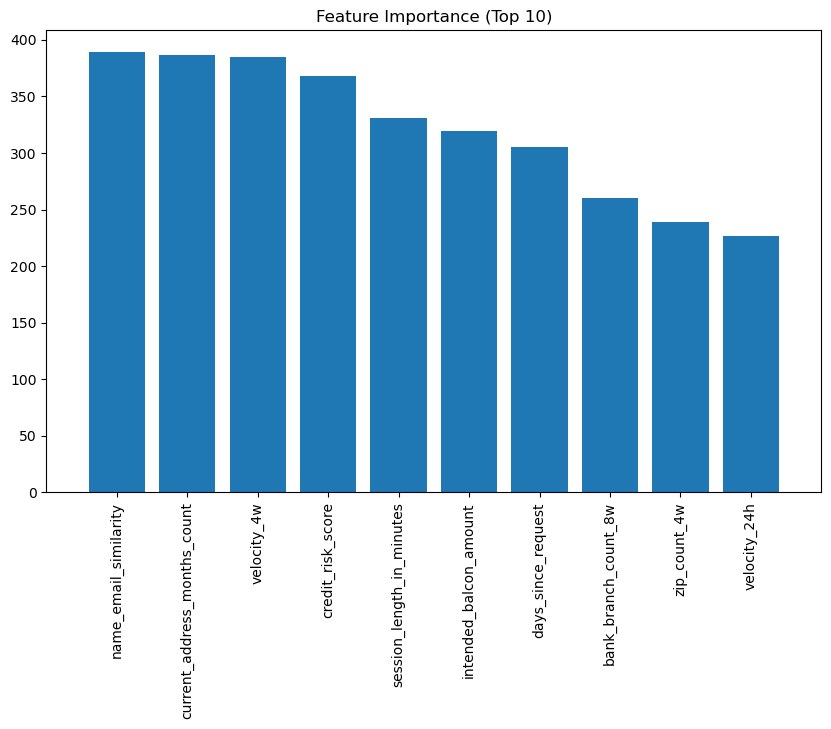

In [24]:

# Load dataset
df = pd.read_csv('Data Sources/Base.csv')
X = df.drop(columns=['fraud_bool'])
y = df['fraud_bool']

# Encode categorical features
categorical_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Best hyperparameters from random search
best_params = {
    'subsample': 1.0,
    'reg_lambda': 1,
    'reg_alpha': 0,
    'num_leaves': 31,
    'n_estimators': 200,
    'min_child_samples': 20,
    'max_depth': 10,
    'learning_rate': 0.05,
    'colsample_bytree': 0.6
}

# Initialize LightGBM model with best parameters
lgb_model = lgb.LGBMClassifier(**best_params, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(lgb_model, X_train, y_train, cv=3, scoring='roc_auc')
print("Cross-validated AUC scores:", cv_scores)
print("Mean cross-validated AUC score:", np.mean(cv_scores))

# Train the model on the entire training set
lgb_model.fit(X_train, y_train)

# Predict on test set
y_pred = lgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model on the test set
accuracy = lgb_model.score(X_test, y_test)
roc_auc = roc_auc_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred.round()).ravel()
fpr = fp / (fp + tn)

print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("False Positive Rate:", fpr)
print("Classification Report:\n", classification_report(y_test, y_pred.round()))

# Visualize feature importance
top_n = 10
importances = lgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_importances = importances[indices][:top_n]
top_features = X.columns[indices][:top_n]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Top 10)")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_features, rotation=90)
plt.xlim([-1, top_n])
plt.show()


# Project Summary

## Introduction
During this project, we aimed to develop and fine-tune a machine learning model to identify fraudulent transactions within a highly imbalanced dataset. We explored various models, conducted hyperparameter tuning, and addressed several challenges related to data imbalance and model performance.

## Models Evaluated
We evaluated the following models:
- **RandomForest**: Achieved the highest accuracy but had a low ROC AUC score, indicating difficulty in distinguishing between classes.
- **XGBoost**: Balanced performance with good accuracy and ROC AUC, suggesting a good balance between false positives and true positives.
- **LightGBM**: Showed strong overall performance with high accuracy, good ROC AUC, and a low false positive rate, making it a reliable choice for our dataset.
- **Logistic Regression**: Struggled with both accuracy and false positive rate, indicating it might not be the best fit.
- **KNN**: Performed decently in terms of accuracy but fell short in ROC AUC and false positive rate compared to ensemble methods.

## Selected Model: LightGBM
Based on the evaluation, we selected **LightGBM** for further tuning due to its strong performance. We focused on optimizing its hyperparameters to further improve its predictive power.

## Hyperparameter Tuning with Randomized Search
To find the best hyperparameters, we used `RandomizedSearchCV`, which significantly reduced the computational time compared to a full grid search. The best hyperparameters were:
- `subsample`: 1.0
- `reg_lambda`: 1
- `reg_alpha`: 0
- `num_leaves`: 31
- `n_estimators`: 200
- `min_child_samples`: 20
- `max_depth`: 10
- `learning_rate`: 0.05
- `colsample_bytree`: 0.6

## Model Performance
### Cross-Validation Results
The cross-validated AUC scores were consistent and high, with an average AUC score of 0.8958:
- Fold 1: 0.8939
- Fold 2: 0.8987
- Fold 3: 0.8948

### Test Set Results
On the test set, the model achieved the following:
- **Accuracy**: 0.98945
- **ROC AUC**: 0.8998
- **False Positive Rate**: 0.00038

### Classification Report:
|               | precision | recall | f1-score | support |
|---------------|:---------:|:------:|:--------:|--------:|
|            0  |    0.99   |  1.00  |   0.99   |  197891 |
|            1  |    0.50   |  0.04  |   0.07   |    2109 |
|   accuracy    |           |        |   0.99   |  200000 |
|   macro avg   |    0.74   |  0.52  |   0.53   |  200000 |
| weighted avg  |    0.98   |  0.99  |   0.98   |  200000 |


## Challenges and Recommendations
### Challenges
- **Data Imbalance**: The dataset was highly imbalanced, which affected performance metrics like recall for the minority class.
- **Low Recall for Minority Class**: The recall for the positive class was low, indicating that the model misses many positive instances.

### To Do's
1. **Handle Data Imbalance**: Use techniques like SMOTE or class weighting to address the imbalance.
2. **Model Calibration**: Calibrate the model's predicted probabilities.
3. **Feature Engineering**: Explore additional features or transformations.
4. **Further Hyperparameter Tuning**: Continue experimenting with hyperparameters.
5. **Ensemble Methods**: Consider combining multiple models for potentially better performance.

## Conclusion
Overall, the LightGBM model demonstrated strong performance and reliability. By addressing the challenges and implementing the recommendations, we can further enhance its performance and ensure it is well-suited for detecting fraudulent transactions.
